In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau, linregress
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score,explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor

import xgboost as xgb

import datarobot as dr

import json

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Helper Functions

In [2]:
def combine_years(base_file_name, years): # for when all of one year is in a dataframe
    df_all = pd.DataFrame()
    for yr in years:
        filename = base_file_name.replace('YYYY', str(yr))
        df = pd.read_csv(filename)
        df_all = pd.concat([df_all, df], axis=0).reset_index(drop=True)
    return df_all

In [3]:
def combine_per_fire_csv(ids, prefix, str_check): #for when a variable is split by fire, takes a list of irwinids
    df_all = pd.DataFrame()
    for i_d in ids:
        for fname in os.listdir(prefix):
            if fname.startswith(i_d) & (str_check in fname):
                df_fire = pd.read_csv(prefix+fname)
                df_all = pd.concat([df_all, df_fire], axis=0).reset_index(drop=True)
    return df_all

In [4]:
def add_to_features(feats, data_to_add): #feats has the multi index of irwinID, day
    #multiindex = data_to_add.set_index(['irwinID', 'day'])
    feats = pd.merge(feats, data_to_add, how='inner', on=['irwinID', 'day']).drop(columns='Unnamed: 0')
    return feats

In [5]:
def generate_feature_vector(years, is_weighted, features_to_use):
    if 'rave' in features_to_use:
        rave = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_RAVE_Unweighted_12Z_day_start.csv', years)
        print('rave', len(rave))
        features = rave[['irwinID','day']].set_index(['irwinID', 'day'])
        features = add_to_features(features, rave).drop_duplicates()
        
    if 'fre' in features_to_use:
        fre = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_fre/', is_weighted)
        print('fre', len(fre))
        features = add_to_features(features, fre).drop_duplicates()
        
    if 'hwp' in features_to_use:
        hwp = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hwp/', is_weighted)
        print('hwp', len(hwp))
        features = add_to_features(features, hwp).drop_duplicates()

    if 'hdw' in features_to_use:
        hdw = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HDW_'+is_weighted+'_12Z_day_start.csv', years)
        print('hdw', len(hdw))
        features = add_to_features(features, hdw).drop_duplicates()
        
    if 'resources' in features_to_use:
        """resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources/', '')"""
        resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources_split/', '')
        print('resources', len(resources))
        features = add_to_features(features, resources).drop_duplicates()
        
    if 'pft' in features_to_use:
        pft = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pft/', is_weighted)
        print('pft', len(pft))
        features = add_to_features(features, pft).drop_duplicates()
        
    if 'smops' in features_to_use:
        smops = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_SMOPS_'+is_weighted+'_12Z_day_start.csv', years)
        print('smops', len(smops))
        features = add_to_features(features, smops).drop_duplicates()

    if 'imerg' in features_to_use:
        imerg = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_IMERG_FWI_'+is_weighted+'_12Z_day_start.csv', years)
        print('imerg', len(imerg))
        features = add_to_features(features, imerg).drop_duplicates()

    if 'pws' in features_to_use:
        pws = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_PWS_'+is_weighted+'_12Z_day_start.csv', years)
        print('pws', len(pws))
        features = add_to_features(features, pws).drop_duplicates()
        
    if 'loading' in features_to_use:
        loading = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_LOADING_'+is_weighted+'_12Z_day_start.csv', years)
        print('loading', len(loading))
        features = add_to_features(features, loading).drop_duplicates()
        

    if 'ncar' in features_to_use:
        ncar = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_ncar/', is_weighted)
        print('ncar', len(ncar))
        features = add_to_features(features, ncar).drop_duplicates()

    
    if 'esi' in features_to_use:
        esi = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_esi/', is_weighted)
        print('esi', len(esi))
        features = add_to_features(features, esi).drop_duplicates()
        
    if 'chi' in features_to_use:
        chi_2019 = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_CHI_'+is_weighted+'_12Z_day_start.csv', years)
        chi_2020 = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_chi/', is_weighted)
        chi= pd.concat([chi_2019, chi_2020], axis=0).reset_index(drop=True)
        print('chi', len(chi))
        features = add_to_features(features, chi).drop_duplicates()
        
    if 'pop' in features_to_use:
        pop = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pop/', is_weighted)
        print('pop', len(pop))
        features = add_to_features(features, pop).drop_duplicates()
        
    if 'structures' in features_to_use:
        structures = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_structures/', '')
        print('structures', len(structures))
        features = add_to_features(features, structures).drop_duplicates()
        
    if 'gridmet' in features_to_use:
        gridmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_gridmet/',is_weighted)
        gridmet= gridmet.rename({'wind_speed': 'wind_speed_gridmet','mean_vapor_pressure_deficit':'vpd_gridmet'}, axis='columns')
        print('gridmet', len(gridmet))
        features = add_to_features(features, gridmet).drop_duplicates()
        
    if 'slope' in features_to_use:
        slope = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_slope/',is_weighted)
        print('slope', len(slope))
        features = add_to_features(features, slope).drop_duplicates()
        
    if 'elevation' in features_to_use:
        elevation = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_elevation/',is_weighted)
        print('elevation', len(elevation))
        features = add_to_features(features, elevation).drop_duplicates()
        
    if 'heatwave' in features_to_use:
        heatwave = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_heatwave/','')
        print('heatwave', len(heatwave))
        features = add_to_features(features, heatwave).drop_duplicates()
        
    if 'hrrrmet' in features_to_use:
        hrrrmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_hrrrmet/',is_weighted)
        hrrrmet= hrrrmet.rename({'wind_speed': 'wind_speed_hrrrmet','vpd_2m':'vpd_hrrrmet'}, axis='columns')
        print('hrrrmet', len(hrrrmet))
        features = add_to_features(features, hrrrmet).drop_duplicates()
        
    return features


In [6]:
def find_outliers(df, col_name):
    quantiles = df[col_name].quantile(q=[.25, .5, .75])
    print(quantiles)
    iqr = quantiles[0.75]-quantiles[0.25]
    lower_fence = quantiles[0.50]-(1.5*iqr)
    upper_fence = quantiles[0.50]+(1.5*iqr)
    print('lower and upper fences are: '+ str(lower_fence) + ', '+ str(upper_fence))
    df[col_name+'_is_outlier'] = np.where((df[col_name]<=lower_fence)| (df[col_name]>=upper_fence), True,False)
    return df

In [7]:
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col, time_col):
    df_shifted = resample_daily(df_to_shift, time_col)
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    return df_shifted

In [8]:
def resample_daily(df_nondaily, time_name):
    df_nondaily['datetime'] = pd.to_datetime(df_nondaily[time_name])
    df_nondaily = df_nondaily.set_index(['datetime'])
    df_daily = df_nondaily.resample('D').asfreq()
    df_daily = df_daily.reset_index()
    return df_daily

In [9]:
def get_dfeatures(df, names, suf_now, suf_back): #to today/yesterday, flip it later
    for name in names:
        df['d'+name+suf_now] = df[name+suf_now]/df[name+suf_back]
    return df

In [10]:
def plot_category_heatmap(data_plot, obs_label, mod_label, model_axis_label):
    conf_mat = confusion_matrix(data_plot[obs_label], data_plot[mod_label], labels=['decrease', 'no_change', 'increase'])
    columns = ['decrease', 'slight \n change', 'increase'] #makes sure the columns are in the right order
    df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
    #swap order of rows and cols
    df_cm_reverse = df_cm.iloc[::-1]

    # Visualize it as a heatmap
    sns.heatmap(df_cm_reverse, annot=True,cmap='rocket_r', fmt='g' ) #fmt g keeps things out of scientific notation
    plt.xlabel(model_axis_label)
    plt.ylabel('True Class')
    plt.show()
    print(classification_report(data_plot[obs_label], data_plot[mod_label]))
    
    
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,7), np.arange(-1,7), 'k-')
    axn.plot(np.arange(-1,7), np.arange(-1,7)*lr.slope+lr.intercept, 'r-')
    axn.text(0.2,3.8,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRP R2='+str(round(errors[0],3))
             +'\n FRP R2='+str(round(errors[1],3))
             +'\n FRP RMSE='+str(round(errors[2],3))
             +'\n FRP MAD='+str(round(errors[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.ylabel('Observed Log(FRP)')
    plt.xlabel(x_axis_label)
    plt.show()


def summarize_error(df, truth_name, log_truth_name, method_name, log_method_name):
    log_r2 =r2_score(df[log_truth_name], df[log_method_name])
    r2 =r2_score(df[truth_name], df[method_name])
    rmse =RMSE(df[truth_name], df[method_name])
    mad =MAD(df[truth_name], df[method_name])
    
    return(log_r2, r2, rmse, mad)

def plot_2dhist_withfit(df_plot, x_data, y_data, log_x_data,log_y_data, inc_cutoff, dec_cutoff, title):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)

    fig, axn = plt.subplots()#figsize=(6,6))
    

    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    sns.histplot(data=df_plot, x=log_x_data, y=log_y_data, bins=20,cbar=True, ax=axn) 
    plt.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    plt.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'b-')
    
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    
    
    #plt.text(-1.6,0.8,log_y_data+'=\n'+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2)), fontsize=12)
    plt.text(-1.4, 0.3,log_y_data+'='+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors[0],3))
             +'\n SF R2='+str(round(errors[1],3))
             +'\n SF RMSE='+str(round(errors[2],3))
             +'\n SF MAD='+str(round(errors[3],3)), fontsize=10)
    plt.title(title)
    plt.show()
    


In [11]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    #thresholds = np.linspace(0,300, 61) #5% increments
    thresholds = np.arange(0,10, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*0.1)) #left hand approximation, assuming bins are 5 wide

# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.nanmean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def MeAD(y_pred,y_test): #aka median error
    return np.nanmedian(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def median_percent_error(y_pred,y_test):
    return(np.nanmedian(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.nanmedian(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

In [12]:
#IN forest: a trained random forest
#IN varnames: names of the training variables, list of strings
#IN plot_title: title of the resulting plot 
def plot_importances(forest, varnames,plot_title):
    tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5
    importances = forest.feature_importances_ #importances for all trees, so if you have 100 trees and 5 features this is a 100x5 (or 5x100) matrix
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    df_plot = pd.DataFrame({'tree_indices': tree_indices, 'importances': importances, 'std':std, 'varnames':varnames})
    df_plot = df_plot.sort_values(by='importances').reset_index(drop=True) #sorts from high to low importance

    #make the figure 
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 20))
    ax1.barh(df_plot.index, df_plot['importances'], height=0.7,xerr = std) #horizontal bar plot
    ax1.set_yticks(df_plot.index) #set the ticks
    ax1.set_yticklabels(df_plot['varnames']) #set the names of the ticks
    ax1.set_ylim((-0.5, len(df_plot['importances']))) #the height of the figure depends on the # of variables plotted
    fig.tight_layout()
    plt.title(plot_title) #title!
    plt.show()

In [13]:
#this function can pick out categories and add in additional variables (1-2 variables recommended for sanity)

def generate_sensitivity_list(feat_dict, category_selected_list, additional_to_append):
    sub = []
    for item in category_selected_list: #add the categories
        sub = sub+feat_dict[item]

    for item2 in additional_to_append: #add the other variables, for instance if we want all categories and then HWP
        sub = sub+[item2]
    
    return sub

# Train-test split

In [19]:
#LOAD IN THE FEATURE CSV
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weighted.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)

In [31]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
#data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

['EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA', '7D2A6B0A-A161-44D9-BFF1-6A68CEA947C5', 'E9DB628D-DFB7-4C85-BCD6-1254574D946B']
133 [2019 2020 2021]
1527 [2020]
1296 [2019 2021]
1296 [2019 2021]


In [33]:
data_train_1921['obs_cat'] = pd.cut(data_train_1921['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])
data_train_1921['persistence_cat'] ='no_change'
data_test_2020['persistence_cat'] ='no_change'

print(len(data_train_1921))
print(str(len(data_train_1921[data_train_1921['obs_cat']=='decrease'])) + ' decreases')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='no_change'])) + ' slight changes')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='increase'])) + ' increases')

1296
466 decreases
450 slight changes
380 increases


In [36]:
#PERSISTENCE AND SCALED METHODS

scaled_methods = ['persistence','dwind_speed_gridmet','dvpd_gridmet','dwind_speed_hrrrmet','dvpd_hrrrmet',
                  'dmax_air_temperature',
                  'dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI','dburning_index_g'] 

scaled_methods_plot =['dwind_speed_hrrrmet','dvpd_gridmet', 'dvpd_hrrrmet','dhwp','dhd1w0','dIMERG.FINAL.v6_FWI','dburning_index_g']
thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 0.5

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'

df_error_metrics_scaled = pd.DataFrame(index=scaled_methods, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',
                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#do the plottint
#drop the nans, these will show up in the scaled methods

data_test_2020= data_test_2020.iloc[np.where((data_test_2020['dhwp']<21.4)&(data_test_2020['dhwp']>0.04)&
                                            (data_test_2020['dhd0w0']<21.4)&(data_test_2020['dhd0w0']>0.04)&
                                            (data_test_2020['dhd1w0']<21.4)&(data_test_2020['dhd1w0']>0.04)&
                                            (data_test_2020['dhd2w0']<21.4)&(data_test_2020['dhd2w0']>0.04)&
                                            (data_test_2020['dhd3w0']<21.4)&(data_test_2020['dhd3w0']>0.04)&
                                            (data_test_2020['dwind_speed_gridmet']<21.4)&(data_test_2020['dwind_speed_gridmet']>0.04)&
                                            (data_test_2020['dvpd_gridmet']<21.4)&(data_test_2020['dvpd_gridmet']>0.04)&
                                            (data_test_2020['dwind_speed_hrrrmet']<21.4)&(data_test_2020['dwind_speed_hrrrmet']>0.04)&
                                            (data_test_2020['dvpd_hrrrmet']<21.4)&(data_test_2020['dvpd_hrrrmet']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_FWI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_FWI']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_BUI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_BUI']>0.04)&
                                            (data_test_2020['dburning_index_g']<21.4)&(data_test_2020['dburning_index_g']>0.04)&
                                            (data_test_2020['denergy_release_component-g']<21.4)&(data_test_2020['denergy_release_component-g']>0.04))]
print(len(data_test_2020))

#do the calculations
for ii in range(len(scaled_methods)):
    #print(scaled_methods[ii])
    #make predictions for all of the holdout year (2020)
    data_test_2020[scaled_methods[ii]+'_logsf'] = np.log10(data_test_2020[scaled_methods[ii]])
    data_test_2020[scaled_methods[ii]+'_sf'] = data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_logfre'] = np.log10(data_test_2020[scaled_methods[ii]+'_fre'])
    data_test_2020[scaled_methods[ii]+'_cat'] = pd.cut(data_test_2020[scaled_methods[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
#print(data_test_2020.columns.values)    
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(data_test_2020))
data_test_2020=data_test_2020.dropna(how='any')
print(len(data_test_2020))

1472
1472
1472


In [22]:
def summarize_error(df, truth_name, method_name, train_vars):
    r2 =r2_score(df[truth_name], df[method_name])
    rmse =RMSE(df[truth_name], df[method_name])
    mad =MAD(df[truth_name], df[method_name])
    
    n = len(df[truth_name].values)
    k = len(train_vars)
    
    adjusted_r2 = 1-(((1-r2)*(n-1))/(n-k-1))
    
    return(r2,adjusted_r2, rmse, mad)

In [23]:
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label, vars_in_model):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    
    errors_fre = summarize_error(df_plot,y_data, x_data, vars_in_model)
    errors_logfre = summarize_error(df_plot, log_y_data, log_x_data,vars_in_model)
        
        
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    axn.set_facecolor('white')

    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,11), np.arange(-1,11), 'k-')
    axn.plot(np.arange(-1,11), np.arange(-1,11)*lr.slope+lr.intercept, 'r-')
    axn.text(4.2,7.7,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRE R2='+str(round(errors_logfre[0],3))
             +'\n FRE R2='+str(round(errors_fre[0],3))
             +'\n FRE Adj. R2='+str(round(errors_fre[1],3))
             +'\n FRE RMSE='+str(round(errors_fre[2],3))
             +'\n FRE MAD='+str(round(errors_fre[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(4,10)
    plt.ylim(4,10)
    plt.ylabel('Observed Log(FRE)')
    plt.xlabel(x_axis_label)
    plt.show()
    
def sf_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, inc_cutoff, dec_cutoff, x_axis_label, vars_in_model):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    
    errors_fre = summarize_error(data_test_2020,y_data, x_data, vars_in_model)
    errors_logfre = summarize_error(data_test_2020, log_y_data, log_x_data,vars_in_model)
        
        
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    axn.set_facecolor('white')
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=np.arange(-1.5,1.5,.2), norm=norm, cmap=cmap)
    
    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    axn.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    axn.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'r-')
    axn.text(-1.5,0.4,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors_logfre[0],3))
             +'\n SF R2='+str(round(errors_fre[0],3))
             +'\n SF Adj. R2='+str(round(errors_fre[1],3))
             +'\n SF RMSE='+str(round(errors_fre[2],3))
             +'\n SF MAD='+str(round(errors_fre[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.ylabel('Observed Log(SF)')
    plt.xlabel(x_axis_label)
    plt.show()

In [25]:
features_by_category = {'raw_weather_gridmet':["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"],
                    'temperatures_gridmet':["max_air_temperature","min_air_temperature","temp_range"], 
                   'raw_weather_hrrr':["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"],
                   'heatwave':["days_in_high_heatwave","days_in_highlow_heatwave","min_air_temperature","max_air_temperature"],
                   'derived_weather_hwp': ["hwp","dhwp"],
                   'derived_weather_hdw': ["dhd0w0","dhd1w0", "dhd2w0", "dhd3w0","hd0w0", "hd1w0", "hd2w0", "hd3w0"],
                   'derived_weather_cffrds': [ "dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"],
                   'derived_weather_nfdrs':[ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"],
                   'stability': ["PFT", "chi","dchi", "dPFT"],
                    'living_moisture':['FMCGLH2D'],
                    'thin_moisture': ['Blended_SM', 'FMCG2D', 'IMERG.FINAL.v6_FFMC'],
                    'mid_moisture':['IMERG.FINAL.v6_DMC', 'dead_fuel_moisture_100hr'],
                    'thick_moisture':['IMERG.FINAL.v6_DC','dead_fuel_moisture_1000hr'],
                   'pws':["PWS"],
                   'esi':["ESI"],
                   'loading': ["Low_N", "Moderate_N", "High_N", "VeryHigh_N", "Extreme_N"],
                   'terrain_slope': ["MEAN_SLOPE","STD_SLOPE"],
                   'terrain_elevation': ["MEAN_ELEV","STD_ELEV"],
                   'DOY': ['DOY'],
                   'containment': ["percent_contained_1"],
                   'resource_personnel': ["crew_personnel_1","engine_personnel_1","air_personnel_1","construction_personnel_1","overhead_personnel_1"],
                   'resource_quantity': ["crew_quantity_1", "engine_quantity_1",  "air_quantity_1", "construction_quantity_1"],
                   'pop': ["POP_DENSITY"],
                   'structures': ["structures_destroyed_1", "structures_damaged_1","structures_threatened_72_1"],
                   'persistence': ["FRE_1"]}
category_list = features_by_category.keys()


In [101]:

#TRY ENGINE PERSONNEL
feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])


feature_subsets['features_raw_gridmet'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                           'hwp','dhwp',
                                           'PFT', 'dPFT', 
                                            'Blended_SM',  'FMCG2D', 'FMCGLH2D',
                                           'PWS','Moderate_N','DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]

feature_subsets['features_hdw'] = ['hd0w0', 'dhd0w0', 
                                   'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',  'FMCG2D', 'FMCGLH2D','PWS','Moderate_N','DOY',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]

feature_subsets['features_can'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                   'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Moderate_N','DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',

                                   'FRE_1' ]

feature_subsets['features_us'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                'Blended_SM','dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Moderate_N', 'DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]


In [102]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_all','features_raw_gridmet','features_hdw',
                    'features_can', 'features_us']


df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    if feature_set_names[ii]=='features_new_all':
        plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    data_test_2020 = data_test_2020.iloc[np.where((data_test_2020['datetime']>=np.datetime64('2020-09-01'))&
                   (data_test_2020['datetime']<=np.datetime64('2020-09-30')))[0],:]
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

    

features_all OOB R2 score is: 0.22039452771926438
features_raw_gridmet OOB R2 score is: 0.2284084247965784
features_hdw OOB R2 score is: 0.19094673765225378
features_can OOB R2 score is: 0.1915729566724551
features_us OOB R2 score is: 0.19412302595417918
DOING PERSISTENCE


In [63]:
print(len(np.where((data_test_2020['datetime']>=np.datetime64('2020-09-01'))&
                   (data_test_2020['datetime']<=np.datetime64('2020-09-30')))[0]))
data_test_sept2020 = data_test_2020.iloc[np.where((data_test_2020['datetime']>=np.datetime64('2020-09-01'))&
                   (data_test_2020['datetime']<=np.datetime64('2020-09-30')))[0],:]
print(data_test_sept2020)

642
       datetime                               irwinID  day      FRP_MEAN  \
0    2020-09-10  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   10  14731.512078   
1    2020-09-11  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   11   2706.065915   
2    2020-09-12  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   12   1349.205056   
3    2020-09-13  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   13    144.146576   
4    2020-09-15  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   15    515.995140   
...         ...                                   ...  ...           ...   
2734 2020-09-10  F3F952C6-B0F0-4655-80C2-A8DCEDD58545   10   2978.707905   
2735 2020-09-11  F3F952C6-B0F0-4655-80C2-A8DCEDD58545   11   5408.406151   
2736 2020-09-12  F3F952C6-B0F0-4655-80C2-A8DCEDD58545   12   3196.551529   
2737 2020-09-14  F3F952C6-B0F0-4655-80C2-A8DCEDD58545   14      2.121452   
2822 2020-09-18  FFCB89F5-98FB-4C3A-9554-3D1554181A63   18   8980.300549   

               FRE        hwp       hd0w0       hd1w0       hd2w0       hd3w0  \
0 

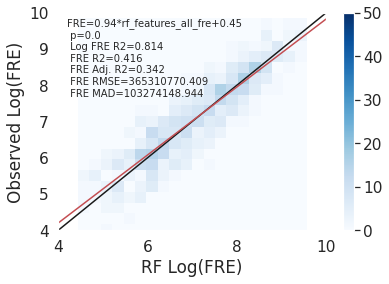

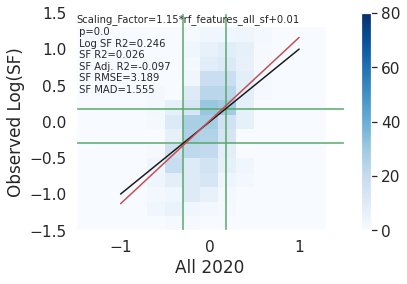

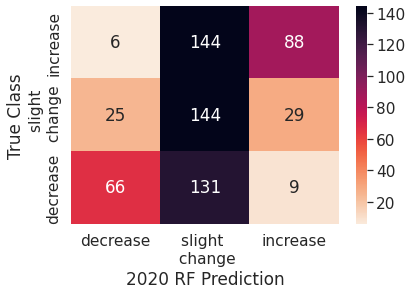

              precision    recall  f1-score   support

    decrease       0.68      0.32      0.44       206
    increase       0.70      0.37      0.48       238
   no_change       0.34      0.73      0.47       198

    accuracy                           0.46       642
   macro avg       0.57      0.47      0.46       642
weighted avg       0.58      0.46      0.46       642



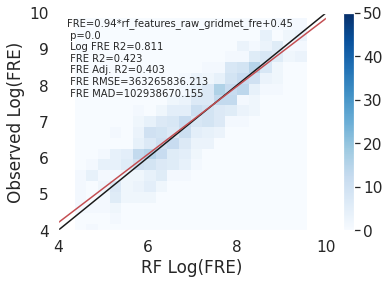

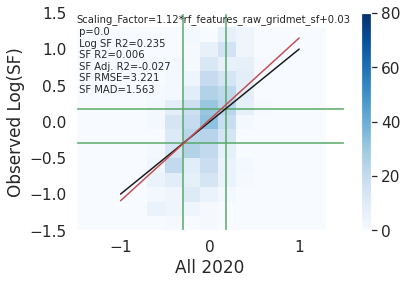

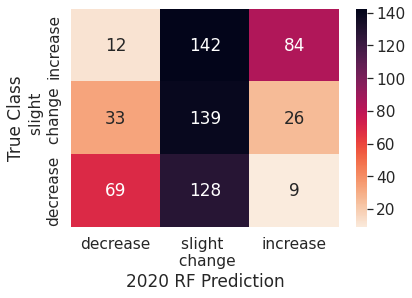

              precision    recall  f1-score   support

    decrease       0.61      0.33      0.43       206
    increase       0.71      0.35      0.47       238
   no_change       0.34      0.70      0.46       198

    accuracy                           0.45       642
   macro avg       0.55      0.46      0.45       642
weighted avg       0.56      0.45      0.45       642



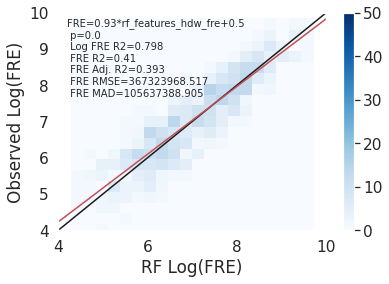

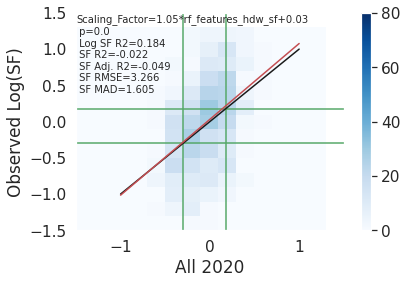

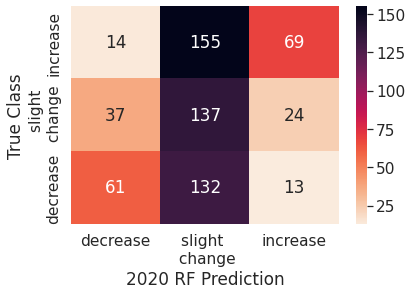

              precision    recall  f1-score   support

    decrease       0.54      0.30      0.38       206
    increase       0.65      0.29      0.40       238
   no_change       0.32      0.69      0.44       198

    accuracy                           0.42       642
   macro avg       0.51      0.43      0.41       642
weighted avg       0.52      0.42      0.41       642



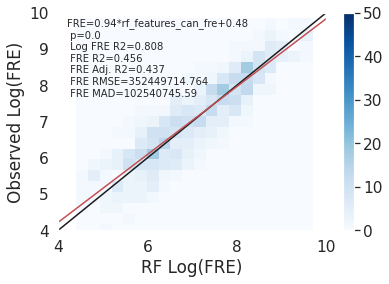

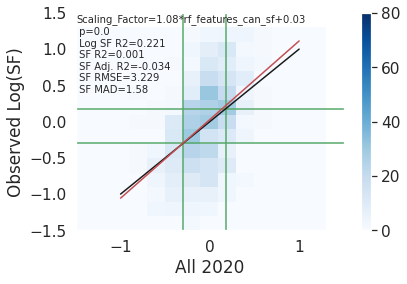

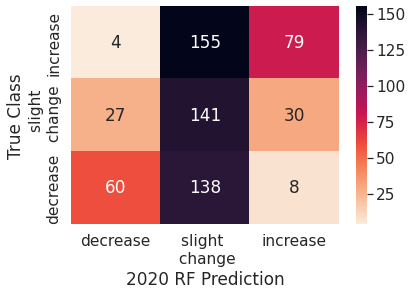

              precision    recall  f1-score   support

    decrease       0.66      0.29      0.40       206
    increase       0.68      0.33      0.45       238
   no_change       0.32      0.71      0.45       198

    accuracy                           0.44       642
   macro avg       0.55      0.45      0.43       642
weighted avg       0.56      0.44      0.43       642



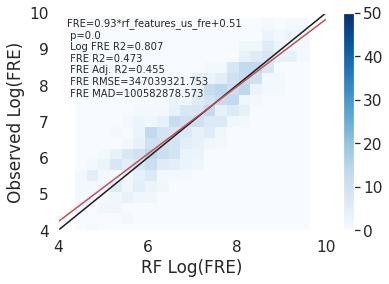

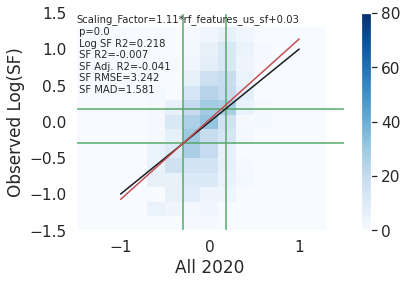

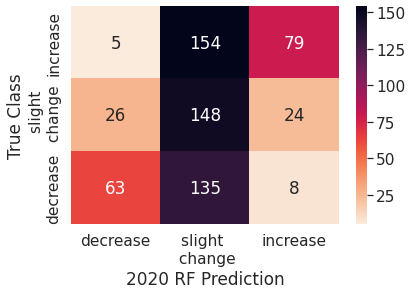

              precision    recall  f1-score   support

    decrease       0.67      0.31      0.42       206
    increase       0.71      0.33      0.45       238
   no_change       0.34      0.75      0.47       198

    accuracy                           0.45       642
   macro avg       0.57      0.46      0.45       642
weighted avg       0.58      0.45      0.45       642



In [98]:
# Plotting, SEPTEMBER
for ii in range(1,len(feature_set_names)):

    frp_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_fre', 'FRE','rf_'+feature_set_names[ii]+'_logfre', 'log_FRE', 'Blues', 0, 50,'RF Log(FRE)',feature_subsets[feature_set_names[ii]])
    
    sf_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_sf', 'Scaling_Factor','rf_'+feature_set_names[ii]+'_logsf', 'Log_Scaling_Factor','Blues',0,80, -.3, .18, 'All 2020',feature_subsets[feature_set_names[ii]])
    plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_'+feature_set_names[ii]+'_cat', '2020 RF Prediction')  



In [44]:
def plot_frp_sensitivity_metrics(df_metrics, vars_plot, reference_label,figsize_tuple):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=figsize_tuple)

    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['percent_change_FRE_RMSE'],df_error_metrics_plot.index,c='orange',s=75, label='RMSE Skill Score')
    p2=ax.scatter(df_error_metrics_plot['percent_change_FRE_MAD'],df_error_metrics_plot.index,c='g',s=75,label='MAD Skill Score')
    p3=twin1.scatter(df_error_metrics_plot['FRE_R2_adj'],df_error_metrics_plot.index, c='b',s=75,label='FRE Adj. R2')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'percent_change_FRE_RMSE'],c='orange', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'percent_change_FRE_MAD'],c='g', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc[reference_label, 'FRE_R2_adj'],c='b', linestyle='--')

    #set properties of the x labels
    #twin1.set_xlim([df_error_metrics_plot['FRE_R2'].min()-.1,df_error_metrics_plot['FRE_R2'].max()+.01])
    twin1.set_xlim([-0.01, 0.55])
    
    #ax.set_xlim([np.min(df_error_metrics_plot[['percent_change_FRE_RMSE', 'percent_change_FRE_MAD']].min().values)-.01,
    #            np.max(df_error_metrics_plot[['percent_change_FRE_RMSE', 'percent_change_FRE_MAD']].max().values)+.01])
    ax.set_xlim([-0.01, 0.25])
    ax.set_xlabel("Skill Score")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("R2")


    twin1.xaxis.label.set_color('b')

    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='b', **tkw)

    ax.legend(handles=[p1, p2, p3], loc="upper left")#bbox_to_anchor=(0.45,1) )

    plt.show()
    
def plot_sf_sensitivity_metrics(df_metrics, vars_plot):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=(9,13))

    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['percent_change_SF_RMSE'],df_error_metrics_plot.index,c='orange',s=75, label='% decrease in RMSE')
    p2=ax.scatter(df_error_metrics_plot['percent_change_SF_MAD'],df_error_metrics_plot.index,c='g',s=75,label='% decrease in MAD')
    p3=twin1.scatter(df_error_metrics_plot['SF_R2'],df_error_metrics_plot.index, c='b',s=75,label='SF R2')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'percent_change_SF_RMSE'],c='orange', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'percent_change_SF_MAD'],c='g', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'SF_R2'],c='b', linestyle='--')

    #set properties of the x labels
    twin1.set_xlim([df_error_metrics['SF_R2'].min(),df_error_metrics['SF_R2'].max()])
    ax.set_xlim([np.min(df_error_metrics[['percent_change_SF_RMSE', 'percent_change_SF_MAD']].min().values),
                 np.max(df_error_metrics[['percent_change_SF_RMSE', 'percent_change_SF_MAD']].max().values)+.01])
    ax.set_xlabel("% decrease")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("R2")


    twin1.xaxis.label.set_color('b')

    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='b', **tkw)

    ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(1,1) )

    plt.show()

def plot_recall_sensitivity_metrics(df_metrics, vars_plot):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=(9,20))
    
    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['increase_recall'],df_error_metrics_plot.index,c='r',s=75, label='increases')
    p2=ax.scatter(df_error_metrics_plot['decrease_recall'],df_error_metrics_plot.index,c='c',s=75,label='decreases')
    p3=twin1.scatter(df_error_metrics_plot['no_change_recall'],df_error_metrics_plot.index, c='tan',s=75,label='slight change')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'increase_recall'],c='r', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'decrease_recall'],c='c', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'no_change_recall'],c='tan', linestyle='--')

    twin1.set_xlim([df_error_metrics['no_change_recall'].min(),df_error_metrics['no_change_recall'].max()])
    ax.set_xlim([0.05, #np.min(df_error_metrics[['percent_change_FRP_RMSE', 'percent_change_FRP_MAD']].min().values),
                 np.max(df_error_metrics[['increase_recall', 'decrease_recall']].max().values)+.01])
    ax.set_xlabel("Percent of observations recalled")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("Percent of slight changes recalled")

    
    twin1.xaxis.label.set_color('tan')


    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='tan', **tkw)

    ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(0.7,1) )

    plt.show()
    
def plot_precision_sensitivity_metrics(df_metrics, vars_plot):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=(9,20))
    
    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['increase_precision'],df_error_metrics_plot.index,c='r',s=75, label='increases')
    p2=ax.scatter(df_error_metrics_plot['decrease_precision'],df_error_metrics_plot.index,c='c',s=75,label='decreases')
    p3=twin1.scatter(df_error_metrics_plot['no_change_precision'],df_error_metrics_plot.index, c='tan',s=75,label='slight change')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'increase_precision'],c='r', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'decrease_precision'],c='c', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc[vars_plot[0], 'no_change_precision'],c='tan', linestyle='--')

    twin1.set_xlim([df_error_metrics['no_change_precision'].min(),df_error_metrics['no_change_precision'].max()])
    ax.set_xlim([0.05, #np.min(df_error_metrics[['percent_change_FRP_RMSE', 'percent_change_FRP_MAD']].min().values),
                 np.max(df_error_metrics[['increase_precision', 'decrease_precision']].max().values)+.01])
    ax.set_xlabel("Precision of modeled categories")
    ax.set_ylabel("Feature Configuration")


    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='tan', **tkw)

    ax.legend(handles=[p1, p2,p3], bbox_to_anchor=(0.4,1) )

    plt.show()

    
def plot_f1_sensitivity_metrics(df_metrics, vars_plot,reference_label,figsize_tuple):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=figsize_tuple)
    
    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['increase_f1'],df_error_metrics_plot.index,c='r',s=75, label='increases')
    p2=ax.scatter(df_error_metrics_plot['decrease_f1'],df_error_metrics_plot.index,c='c',s=75,label='decreases')
    p3=ax.scatter(df_error_metrics_plot['no_change_f1'],df_error_metrics_plot.index, c='tan',s=75,label='slight change')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'increase_f1'],c='r', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'decrease_f1'],c='c', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'no_change_f1'],c='tan', linestyle='--')

    #twin1.set_xlim([df_error_metrics['no_change_f1'].min(),df_error_metrics['no_change_f1'].max()])
    #ax.set_xlim([np.min(df_error_metrics_plot[['increase_f1', 'decrease_f1', 'no_change_f1']].min().values)-.01,
    #             np.max(df_error_metrics_plot[['increase_f1', 'decrease_f1', 'no_change_f1']].max().values)+.005])
    ax.set_xlim([-0.01, 0.55])
    ax.set_xlabel("F1 Score")
    ax.set_ylabel("Feature Configuration")


    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', color=[1,0,0,0],labelcolor=[1,0,0,0],**tkw)

    ax.legend(handles=[p1, p2,p3], loc="upper left")# bbox_to_anchor=(0.45,1) )

    plt.show()

In [45]:
def plot_correlations(df_all, fig_title,correlation_type, font_size, figsize_tuple):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=figsize_tuple)
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':font_size})
    plt.title(fig_title, fontsize=30)
    plt.show()

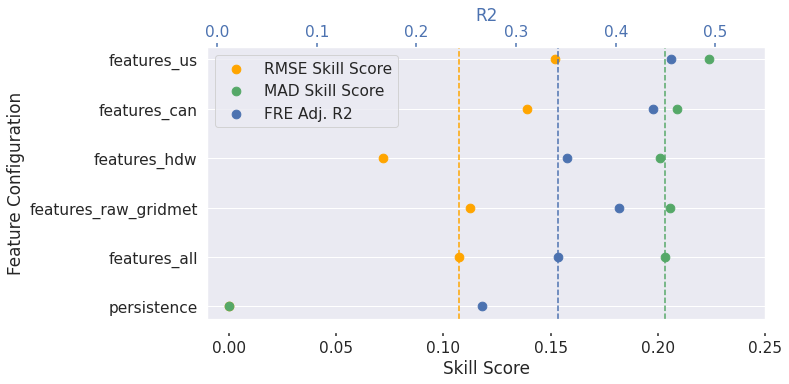

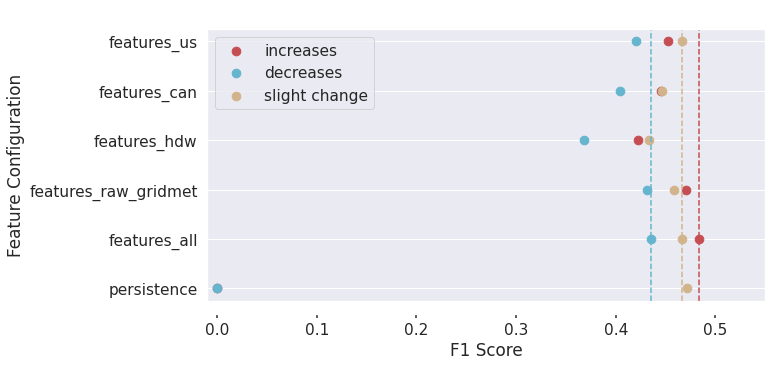

In [103]:
opt_subsets = ['persistence','features_all','features_raw_gridmet','features_hdw',
                    'features_can', 'features_us']


plot_frp_sensitivity_metrics(df_error_metrics_rf, opt_subsets,'features_all',(10,5))
plot_f1_sensitivity_metrics(df_error_metrics_rf, opt_subsets,'features_all',(10,5))

In [95]:
print(type(data_test_2020['datetime']))
print(type(data_test_2020.loc[:,feature_subsets['features_hdw']]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [92]:
print(feature_subsets['features_hdw'])

['hd0w0', 'dhd1w0', 'hwp', 'dhwp', 'PFT', 'dPFT', 'Blended_SM', 'FMCG2D', 'FMCGLH2D', 'PWS', 'Moderate_N', 'DOY', 'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1', 'engine_personnel_1', 'FRE_1', ['dateitme'], ['dateitme']]


In [106]:
print(pd.concat([pd.DataFrame(data_test_2020.loc[:,'datetime']),pd.DataFrame(data_test_2020.loc[:,'irwinID']),
                 data_test_2020.loc[:,feature_subsets['features_hdw']],
                 pd.DataFrame(data_test_2020['rf_features_hdw_fre'])],axis=1)[0:20])

      datetime                               irwinID       hd0w0    dhd0w0  \
0   2020-09-10  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   76.251916  0.458325   
1   2020-09-11  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   45.794999  0.600575   
2   2020-09-12  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   40.359152  0.881300   
3   2020-09-13  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   38.327457  0.949660   
4   2020-09-15  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   39.919948  1.289509   
5   2020-09-16  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   38.297572  0.959359   
6   2020-09-17  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   36.925953  0.964185   
31  2020-09-04  07A2F787-CF35-46AB-92FB-EEA413392BE3   59.365507  0.978808   
32  2020-09-06  07A2F787-CF35-46AB-92FB-EEA413392BE3   61.069393  0.748359   
34  2020-09-10  07A2F787-CF35-46AB-92FB-EEA413392BE3   53.910563  1.486210   
35  2020-09-11  07A2F787-CF35-46AB-92FB-EEA413392BE3   54.601316  1.012813   
36  2020-09-12  07A2F787-CF35-46AB-92FB-EEA413392BE3   46.412885

In [ ]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_all','features_hdw']


df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    if feature_set_names[ii]=='features_new_all':
        plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

    